## Data PreProcessing

In [82]:
import numpy as np
import yfinance as yf
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten

In [84]:
# stock_ticker = yf.Ticker("msft")
stock_ticker = yf.Ticker("TLS.AX")
#stock_ticker = yf.Ticker("RELIANCE.NS")

In [85]:
#Processing data fro data set
stock_data = stock_ticker.history(period="max")

stock_data['Avg_low_high'] = (stock_data['Low'] + stock_data['High'])/2
stock_data['Avg_open_close'] = ( stock_data['Open'] + stock_data['Close'] )/2

del stock_data['Dividends'] , stock_data['Stock Splits']
del stock_data['Volume']
del stock_data['Open']
del stock_data['High']
del stock_data['Low']
del stock_data['Close']

stock_data.to_csv()
stock_data = stock_data.loc['1990-01-01': ].copy()
print(type(stock_data))

stock_data

<class 'pandas.core.frame.DataFrame'>


,Avg_low_high,Avg_open_close
Date,,
1997-12-01 00:00:00+11:00,0.904473,0.904473
1997-12-02 00:00:00+11:00,0.904473,0.904473
1997-12-03 00:00:00+11:00,0.904473,0.904473
1997-12-04 00:00:00+11:00,0.904473,0.904473
1997-12-05 00:00:00+11:00,0.904473,0.904473
...,...,...
2023-05-23 00:00:00+10:00,4.342500,4.350000
2023-05-24 00:00:00+10:00,4.330000,4.335000
2023-05-25 00:00:00+10:00,4.330000,4.345000


In [86]:
full_length = len(stock_data)
# required_time_frame_in_days = (2023 - 1990)*252
# back_shift is number of days to go back from now eg 10 so 27th may-10 = 17 may
back_shift = 0
stock_data = stock_data[0 : full_length - back_shift]
print(len(stock_data))

6454


In [87]:
stock_data.head()
stock_data.tail()

,Avg_low_high,Avg_open_close
Date,,
2023-05-23 00:00:00+10:00,4.3425,4.350
2023-05-24 00:00:00+10:00,4.3300,4.335
2023-05-25 00:00:00+10:00,4.3300,4.345
2023-05-26 00:00:00+10:00,4.3500,4.355
2023-05-29 00:00:00+10:00,4.3650,4.365


In [88]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

Enter the number of days the lstm model should acount for while giving a prediction ,  somewhat equal to no of points duirng linear regresion . 

In [89]:
# define input sequence
timeseries_data = stock_data['Avg_low_high']
# choose a number of time steps
n_steps = int(input("Enter the no. of fsteps :  "))
#n_steps = 3
# split into samples
X, y = prepare_data(timeseries_data, n_steps)
#
print(X),print(y)

Enter the no. of fsteps :  3
[[0.90447325 0.90447325 0.90447325]
 [0.90447325 0.90447325 0.90447325]
 [0.90447325 0.90447325 0.90447325]
 ...
 [4.36000013 4.34249997 4.32999992]
 [4.34249997 4.32999992 4.33000016]
 [4.32999992 4.33000016 4.3499999 ]]
[0.90447325 0.90447325 0.90447325 ... 4.33000016 4.3499999  4.36500001]


(None, None)

In [90]:
X.shape

(6451, 3)

In [91]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
type(X)

numpy.ndarray

In [92]:

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=10, verbose=1) # For test use
# model.fit(X, y, epochs=500, verbose=1) For producton use

Epoch 1/10
202/202 [==============================] - 5s 8ms/step - loss: 1.0972
Epoch 2/10
202/202 [==============================] - 2s 9ms/step - loss: 0.0085
Epoch 3/10
202/202 [==============================] - 1s 6ms/step - loss: 0.0063
Epoch 4/10
202/202 [==============================] - 1s 6ms/step - loss: 0.0028
Epoch 5/10
202/202 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 6/10
202/202 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 7/10
202/202 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 8/10
202/202 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 9/10
202/202 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 10/10
202/202 [==============================] - 1s 7ms/step - loss: 0.0020


In [93]:
#N = int(input("Enter no. of days"))
No_of_days = 10
# len(hist['Avg_low_high'])-n_steps

In [94]:
# demonstrate prediction for next N days
stock_data_len = len(stock_data['Avg_low_high'])
# x_input = np.array([
#                     stock_data['Avg_low_high'][stock_data_len - 3], Previous method for 3 stage data
#                     stock_data['Avg_low_high'][stock_data_len - 2],
#                     stock_data['Avg_low_high'][stock_data_len - 1]])
x_input = np.array([stock_data['Avg_low_high'][stock_data_len - n_steps:stock_data_len]])

temp_input=list(x_input)
lst_output=[]
i=0
while(i<No_of_days):
    
    if(len(temp_input)>n_steps): #here 3 was replaced by n_steps was 
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
print(lst_output)
print("Done")

[4.313046]
[4.313046]
[4.313046]
3 day input [4.313046 4.313046 4.313046]
3 day output [[4.283231]]
4 day input [4.313046 4.313046 4.283231]
4 day output [[4.2777147]]
5 day input [4.313046  4.283231  4.2777147]
5 day output [[4.2674646]]
6 day input [4.283231  4.2777147 4.2674646]
6 day output [[4.248437]]
7 day input [4.2777147 4.2674646 4.248437 ]
7 day output [[4.2388897]]
8 day input [4.2674646 4.248437  4.2388897]
8 day output [[4.2259345]]
9 day input [4.248437  4.2388897 4.2259345]
9 day output [[4.2107506]]
[4.313046, 4.313046, 4.313046, 4.283231, 4.2777147, 4.2674646, 4.248437, 4.2388897, 4.2259345, 4.2107506]
Done


In [95]:
# hist_len = len(hist['Avg_low_high'])
# print(hist['Avg_low_high'][hist_len - 3])
# print(hist['Avg_low_high'][hist_len - 2])
# print(hist['Avg_low_high'][hist_len - 1])
# hist

## Visualising the output

In [96]:
import matplotlib.pyplot as plt
stock_dates = stock_data.index


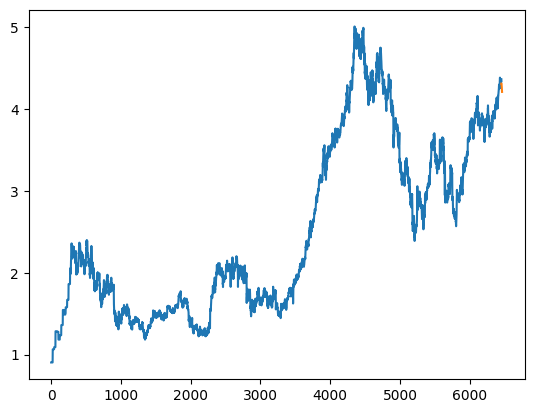

In [97]:
day_new=np.arange(0,stock_data_len)
day_pred=np.arange(stock_data_len , stock_data_len + No_of_days)

#plt.plot(stock_dates , timeseries_data)
plt.plot(day_new , timeseries_data)
plt.plot(day_pred,lst_output)

## Project Over ------------------------------------------------------------------------------------------------------------------------------------------------------------->

In [ ]:
stock_dates = stock_data.index
stock_dates

DatetimeIndex(['1990-01-02 00:00:00-05:00', '1990-01-03 00:00:00-05:00',
               '1990-01-04 00:00:00-05:00', '1990-01-05 00:00:00-05:00',
               '1990-01-08 00:00:00-05:00', '1990-01-09 00:00:00-05:00',
               '1990-01-10 00:00:00-05:00', '1990-01-11 00:00:00-05:00',
               '1990-01-12 00:00:00-05:00', '1990-01-15 00:00:00-05:00',
               ...
               '2023-05-15 00:00:00-04:00', '2023-05-16 00:00:00-04:00',
               '2023-05-17 00:00:00-04:00', '2023-05-18 00:00:00-04:00',
               '2023-05-19 00:00:00-04:00', '2023-05-22 00:00:00-04:00',
               '2023-05-23 00:00:00-04:00', '2023-05-24 00:00:00-04:00',
               '2023-05-25 00:00:00-04:00', '2023-05-26 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=8416, freq=None)

In [ ]:
type(day_new)
day_pred

array([6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898])

In [ ]:
type(stock_dates)

pandas.core.indexes.datetimes.DatetimeIndex